**Install and import the required libraries**

In [37]:
! pip install pyarrow
! pip install pyshp
! pip install shapely
! pip install descartes

In [38]:
# Import libraries
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

In [39]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
# Create variable YEARS with the years interested in this study:
YEARS = [2019, 2020, 2021]

In [41]:
# Download the Trip Record Data for YEARS
# Progress bars below are build by tdqm
for year in tqdm(YEARS):
    if not os.path.exists(f'data/{year}'): #check if path "data/YEAR" exists ('if not' executes only if False)
        os.makedirs(f'data/{year}', exist_ok=True) #create diretory and folder "data/YEAR"
        for month in tqdm(range(1, 13)): #loop over months on website, from tqdm get bar progress
            urllib.request.urlretrieve(f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet', f'data/{year}/{month:02d}.parquet')
#dit not get if the .parquet file was already in the website or we are building this file type            

  0%|          | 0/3 [00:00<?, ?it/s]

In [42]:
#reads a .parquet file and converts into a Data Frame
def load_table(year, month): 
    """
    Function that reads the downloaded data and converts it to a DataFrame
    """
    return pq.read_table(f'data/{year}/{str(month).zfill(2)}.parquet').to_pandas() #zfill add zeros to indicated length

In [43]:
#create list of required data
required_data = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 
                 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'total_amount']

def clean_data(data, year, month, sampling = 1000):
    """
    Function that clears the month data.
    """
    
    #uniform sampling
    data = data[::sampling] 
    
    #getting required columns from sample
    data = data[required_data] 
    
    #boolean condition, get only: "The pick-up is after the drop-off"
    data = data[data.tpep_pickup_datetime < data.tpep_dropoff_datetime] 
    
    #boolean condition, get only: trips with at least one passenger
    data = data[data.passenger_count > 0]
    
    #eliminate nan from data
    data = data[np.logical_not(np.isnan(data.passenger_count))] 
    
    #create a new column 'year' in Data Frame
    data['year'] = year
    
    return data

In [44]:
def post_processing(data):
    
    """
    Function to implement any type of post-processing required.
    """
    
    #convert miles to km
    data['trip_distance'] = data['trip_distance'] * 1.6 
    
    #create new column to have month pickup
    data['month pickup'] = data.tpep_pickup_datetime.dt.month
    
    #new columns for visualization
    
    data['pickup_month'] = data['tpep_pickup_datetime'].dt.month
    
    data['dropoff_month'] = data['tpep_dropoff_datetime'].dt.month
    
    data['pickup_week'] = data['tpep_pickup_datetime'].dt.isocalendar().week
    
    data['dropoff_week'] = data['tpep_dropoff_datetime'].dt.isocalendar().week

    data['pickup_hour'] = data.tpep_pickup_datetime.dt.hour
    
    data['dropoff_hour'] = data.tpep_dropoff_datetime.dt.hour
    
    data['pickup_day'] = data.tpep_pickup_datetime.dt.dayofweek
    
    data['dropoff_day'] = data.tpep_dropoff_datetime.dt.dayofweek
    
    data['pickup_dayofyear'] = data.tpep_pickup_datetime.dt.dayofyear
    
    data['dropoff_dayofyear'] = data.tpep_dropoff_datetime.dt.dayofyear
    
    data['trip_duration'] = pd.to_datetime(data.tpep_dropoff_datetime)  - pd.to_datetime(data.tpep_pickup_datetime)
    data['trip_duration'] = data['trip_duration'].dt.seconds/3600
    
    data['trip_speed'] = data['trip_distance'] / data['trip_duration']
    
    return data
    

In [45]:
#Generate Data Frame with all required data for YEARS: 2019, 2020, 2021
df = pd.concat([clean_data(load_table(year, month), year, month) 
                for year in tqdm(YEARS) 
                for month in tqdm(range(1, 13), leave = False)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [46]:
#Post processing the data
df = post_processing(df)
#df.shape

In [47]:
#Visualize Data Frame 
df.head(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,pickup_week,dropoff_week,pickup_hour,dropoff_hour,pickup_day,dropoff_day,pickup_dayofyear,dropoff_dayofyear,trip_duration,trip_speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.400,151,239,1,7.0,9.95,2019,...,1,1,0,0,1,1,1,1,0.111111,21.600000
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,3.056,148,137,2,8.5,9.80,2019,...,1,1,0,1,1,1,1,1,0.135278,22.590554
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,12.320,264,264,1,26.0,31.30,2019,...,1,1,0,1,1,1,1,1,0.489444,25.171396
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,2.240,249,164,1,7.5,11.40,2019,...,1,1,0,1,1,1,1,1,0.140833,15.905325
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,1.072,162,137,2,4.0,5.30,2019,...,1,1,0,0,1,1,1,1,0.050000,21.440000
5000,2019-01-01 00:29:00,2019-01-01 00:46:19,1.0,4.336,161,262,1,13.5,17.76,2019,...,1,1,0,0,1,1,1,1,0.288611,15.023677
6000,2019-01-01 00:16:51,2019-01-01 00:33:46,1.0,11.360,144,82,2,22.5,23.80,2019,...,1,1,0,0,1,1,1,1,0.281944,40.291626
7000,2019-01-01 00:40:11,2019-01-01 00:45:02,5.0,1.792,43,237,1,6.0,8.76,2019,...,1,1,0,0,1,1,1,1,0.080833,22.169072
8000,2019-01-01 00:41:49,2019-01-01 00:47:09,1.0,2.112,74,263,2,6.0,7.30,2019,...,1,1,0,0,1,1,1,1,0.088889,23.760000
9000,2019-01-01 00:49:25,2019-01-01 01:16:02,1.0,8.576,249,262,1,21.0,26.76,2019,...,1,1,0,1,1,1,1,1,0.443611,19.332248


### Number of trips by year

In [48]:
def bar_plot(df, column, xlabel, ylabel, title):
    
    """
    A function that creates a bar figure from the dataframe *df* 
    according to the content of the *column*.
    """
    
    plt.bar(*np.unique(df[column], return_counts = True)) #np.unique: returns the sorted unique elements of an array
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    plt.xticks(YEARS) 
    

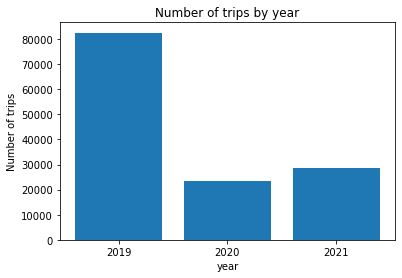

In [49]:
#Call function to plot 
bar_plot(df, 'year', 'year', 'Number of trips', 'Number of trips by year')

**Visualize how many passengers there are per taxi and per year (%)**.

In [50]:
def passengers_taxi(df, xlabel, ylabel, norm = False):
    """
    Function that displays how many passengers there are per taxi
    """
    
    #find max and min of passengers numbers
    min_passenger = int(min(df['passenger_count']))
    max_passenger = int(max(df['passenger_count']))

    #put max and min of passengers numbers in a list
    passengers_per_taxi = range(min_passenger,max_passenger+1)

    passengers_per_year = []

    for year in YEARS:
        passengers_list = []
        for i in passengers_per_taxi: 
            total_by_passenger = df.query('year ==' +str(year) + 'and passenger_count == '+str(i))['passenger_count'].sum()
            passengers_list.append(total_by_passenger)
        passengers_per_year.append(passengers_list)    
        
        
    #condition %
    if norm == True:
        passenger_per_year_norm = (passengers_per_year-np.min(passengers_per_year))/(np.max(passengers_per_year)-np.min(passengers_per_year))
         
    
    #bar plot all years =! colors
    X = passengers_per_taxi

    barWidth = 0.25
    
    r1 = np.arange(len(passengers_per_taxi))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    plt.bar(r1, passengers_per_year[0], width=barWidth, label = '2019', color=['green'])
    plt.bar(r2, passengers_per_year[1], width=barWidth, label = '2020', color=['blue'])
    plt.bar(r3, passengers_per_year[2], width=barWidth, label = '2021', color=['orange'])
    
    
    plt.xticks(r1, X)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

    


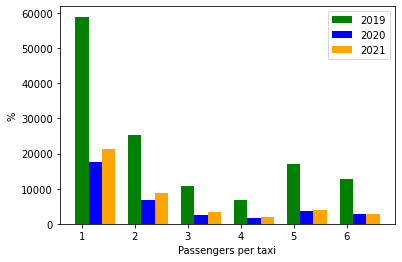

In [51]:
passengers_taxi(df, 'Passengers per taxi', '%', norm = True) 

**Number of trips**

In [52]:
def visualize_trips(df, columns, title, xlabel, ylabel):
    """
    Function that visualizes the number of trips by different data aggregations
    """
    
    for i in range(len(columns)):
        col = columns[i]  
        for year in YEARS:
            counts = df.loc[df.year == year, col].value_counts().sort_index()
            plt.plot(counts.index, counts.values, linestyle = 'dashed', color = 'gray')    
            plt.scatter(counts.index, counts.values, label = year)
        
        
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

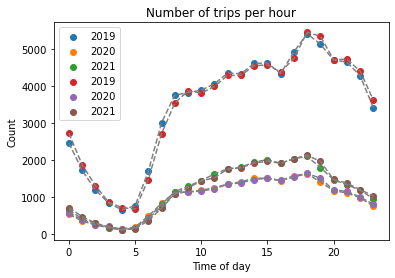

In [53]:
visualize_trips(df, ['pickup_hour', 'dropoff_hour'], title = 'Number of trips per hour', xlabel = 'Time of day', ylabel = 'Count')

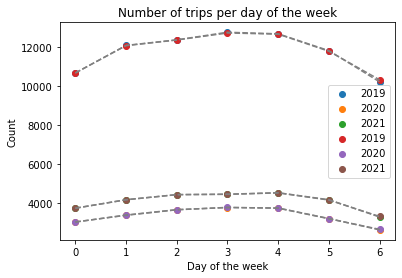

In [54]:
visualize_trips(df, ['pickup_day', 'dropoff_day'], title = 'Number of trips per day of the week', xlabel = 'Day of the week', ylabel = 'Count')

**Visualize the locations of the trips**

In [55]:
from utils import get_lat_lon, draw_region_map, draw_zone_map

In [56]:
sf = shapefile.Reader('data/geodata/taxi_zones.shp')

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [57]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shp_dic).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171533,40.689483
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822478,40.610824
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844953,40.865747
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977725,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187558,40.550664


/opt/anaconda3/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


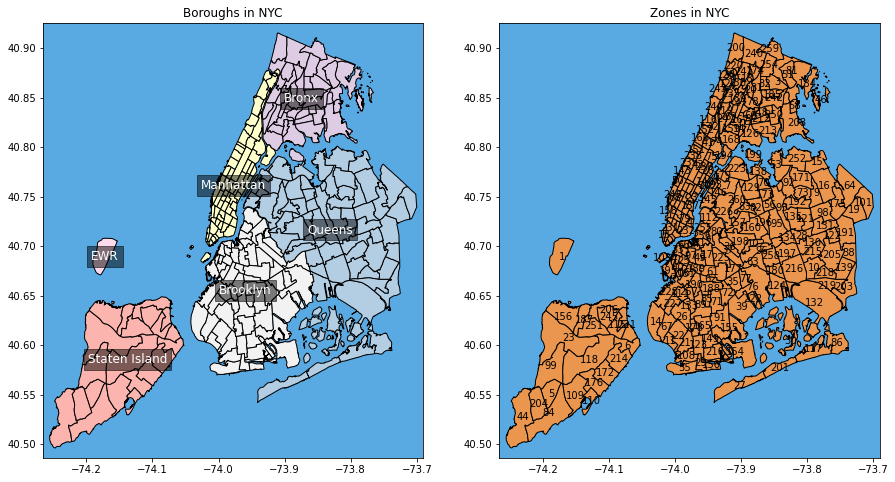

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf, shp_dic)

ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf, shp_dic)

In [59]:
#dataframe merge
merge = pd.merge(df, df_loc, left_on = 'PULocationID', right_on = 'LocationID')

In [60]:
#merge.shape

In [61]:
df_loc

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171533,40.689483
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822478,40.610824
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844953,40.865747
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977725,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187558,40.550664
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,-73.856334,40.899061
259,260,0.133514,0.000422,Woodside,260,Queens,-73.906851,40.746603
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,-74.012643,40.709120
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,-73.945142,40.776681


**Which are the areas/zones with more pick-up and drop-off?**

In [62]:
#Function to compute the dataframe

def data_frame_locations(LocationID):

    year_list = []
    LocationID_list = []
    count_list = []
    

    for year in YEARS:
        counts = df.loc[df.year == year, LocationID].value_counts().sort_index()
        LocationID_list.append(counts.index)
        count_list.append(counts.values)
        year_list.append([year]*len(counts.values))
        

    data_year = year_list[0] + year_list[1] + year_list[2]
    data_LocationID_list = LocationID_list[0].tolist() + LocationID_list[1].tolist() + LocationID_list[2].tolist()
    data_count_list = count_list[0].tolist() + count_list[1].tolist() + count_list[2].tolist()

    data = (data_year, data_LocationID_list , data_count_list)
    
    data_dataframe = pd.DataFrame(data).T 
    
    return data_dataframe
    

In [63]:
# Pick-up    
top_pu = data_frame_locations('PULocationID')
top_pu.columns = ['year', 'PULocationID', 'count']

# Drop-off
top_do = data_frame_locations('DOLocationID')
top_do.columns = ['year', 'DOLocationID', 'count']


In [64]:
n_top = 5

def show_top_n(df, column, df_loc, n_top = n_top):
    
    """
    Function that print the most common zones by year
    """
    
    for year in YEARS:
        df_location = df.loc[df.year == year, (column,'count')]
        sort_df_values = df_location.sort_values(by='count', ascending = False)
        n_top_location_ID = (sort_df_values[column].iloc[0:n_top]).values
        
        print('Year:' + str(year))
        
        for ID in n_top_location_ID:
            df_zones = df_loc.loc[df_loc.LocationID == ID, 'zone']
            zones = df_zones.values
            print(zones)
        
        print("\n")


In [65]:
show_top_n(top_pu, 'PULocationID', df_loc)

Year:2019
['Upper East Side South']
['Midtown Center']
['Upper East Side North']
['Midtown East']
['Penn Station/Madison Sq West']


Year:2020
['Upper East Side South']
['Upper East Side North']
['Midtown Center']
['Midtown East']
['Penn Station/Madison Sq West']


Year:2021
['Upper East Side South']
['Upper East Side North']
['Midtown Center']
['JFK Airport']
['Penn Station/Madison Sq West']




In [66]:
show_top_n(top_do, 'DOLocationID', df_loc)

Year:2019
['Upper East Side North']
['Midtown Center']
['Upper East Side South']
['Murray Hill']
['Midtown East']


Year:2020
['Upper East Side North']
['Upper East Side South']
['Midtown Center']
['Lenox Hill West']
['Murray Hill']


Year:2021
['Upper East Side North']
['Upper East Side South']
['Midtown Center']
['Murray Hill']
['Upper West Side South']




**Heat map with the most common zones**

/opt/anaconda3/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/opt/anaconda3/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/opt/anaconda3/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


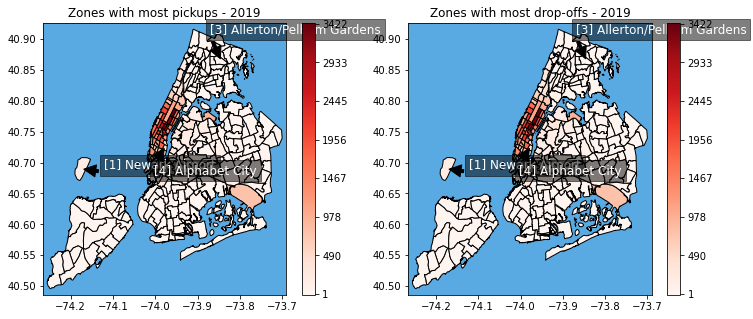

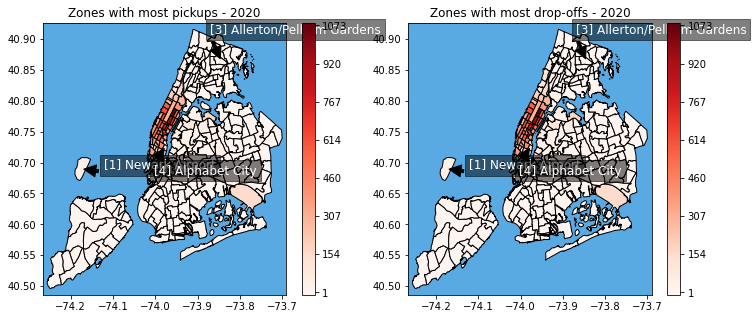

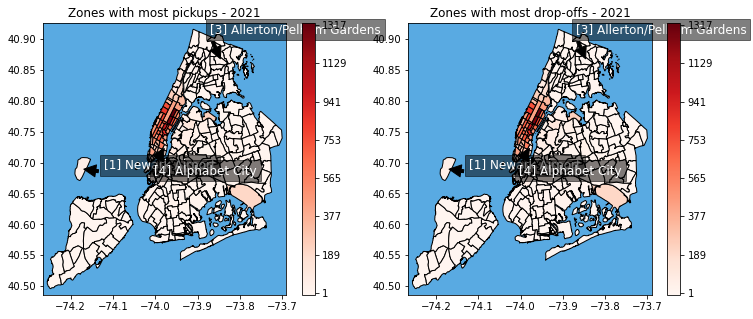

In [67]:
for year in YEARS:
    
    PUcount = {k:v for k, v in top_do[top_do.year == year][['DOLocationID', 'count']].values}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    ax = plt.subplot(1, 2, 1)
    ax.set_title(f"Zones with most pickups - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f"Zones with most drop-offs - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])

**Hospitals**

In [68]:
#DataFrame with the most important hospitals in New York and their locations.

hospitals = [('New York’s Presbyterian Lower Manhattan Hospital, NYC, NY, USA', '40.710255', '-74.005058'),
('Manhattan Gastroenterology, NYC, NY, USA', '40.778259', '-73.958092'),
('Stem Cell Therapy Hospital, NYC, NY, USA', '40.601517', '-73.961067'),
('Park Avenue Smiles, Yonkers, NYC, NY, USA', '40.945873', '-73.890671'),
('Cosmetic Dentistry Center, NYC, NY, USA', '40.629234', '-74.026077'),
('Envy Smile Dental Spa, Brooklyn, NYC, NY, USA', '40.607059', '-73.960144'),
('VIVA EVE, Forest Hills, NYC, NY, USA', '40.734291', '-73.849434'),
('Forest Hills Medical Services, Queens, NYC, NY, USA', '40.734310', '-73.849510'),
('Professional Gynecological Services, Brooklyn, NY, NY, USA', '40.689747', '-73.982346'),
('Manhattan Womens Health & Wellness, New York, NY, USA', '40.741997', '-73.986107'),
('Brooklyn Abortion Clinic, Brooklyn, NY, New York, USA', '40.689743', '-73.982368'),
('Brooklyn GYN Place, Brooklyn, NY, USA', '40.692696', '-73.993584'),
('Americas Holistic Doctor, NYC, NY, USA', '40.742531', '-73.985489'),
('NJS Physical Medicine & Rehabilitation, Brooklyn, NY, USA', '40.641621', '-73.956734'),
('DHD Medical, Brooklyn New York, USA', '40.625568', '-73.918320'),
('Workers Compensation Doctor, New York, NY, USA', '40.652225', '-74.006104'),]

hospitals = pd.DataFrame(hospitals, columns = ['Place Name', 'Latitude', 'Longitude'])
hospitals['Latitude'] = hospitals['Latitude'].astype(float)
hospitals['Longitude'] = hospitals['Longitude'].astype(float)
hospitals.head()

,Place Name,Latitude,Longitude
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077


In [69]:
def scatter_locations(merge, hospitals):
    """Function showing the distribution of hospitals and taxi destinations"""
        
    #Scatter plot hospitals
    #(hospitals)
    plt.scatter(merge.longitude, merge.latitude)
    plt.scatter(hospitals.Longitude, hospitals.Latitude)


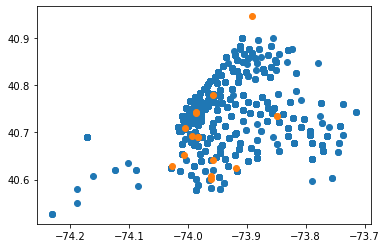

In [70]:
scatter_locations(merge, hospitals)

In [71]:
def scatter_locations_per_year(merge, hospitals):
    """Function showing the distribution of hospitals and taxi destinations per year"""
    
    #sum to index axs plots
    i = 0
    
    #create subplot
    fig, axs = plt.subplots( 1, len(YEARS), figsize = (14, 4)) # (rows, columns, panel number)
    
    for year in YEARS:
        merge_longitude = merge.loc[merge.year == year ,"longitude"]
        merge_latitude = merge.loc[merge.year == year ,"latitude"]
        #scatter plot
        axs[i].scatter(merge_longitude, merge_latitude, alpha=0.3)
        axs[i].scatter(hospitals.Longitude, hospitals.Latitude)
        axs[i].set_title(str(year))
        i += 1

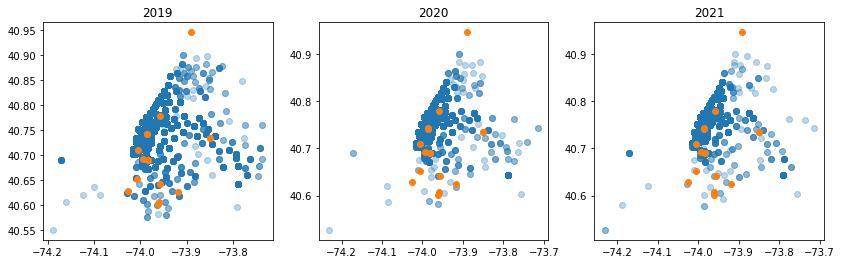

In [72]:
scatter_locations_per_year(merge, hospitals)